# Proto-persona clustering process

This notebook is shorter version of a clustering approach for persona development as described here: https://github.com/TjarkGall/proto-persona-clustering

## Notebook set up

In [1]:
# Load packages (if you get errors, you can install them, for example, by using typing:
# conda install [package name] 
# pip install [package name] 
# in the terminal. 

import os
import random
import datetime
import itertools
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy import stats
from collections import Counter

In [2]:
# Activate autosaving every 180 seconds to ensure that no data is lost
%autosave 180

Autosaving every 180 seconds


In [3]:
# Move working directory one level up to be in overall folder
# ATTENTION: If this is run more than once, it always moves on level up
os.chdir("..")

# Print working directory. It should be the folder in which there is the data folder
os.getcwd()

'/Users/tjark/Documents/Python/CairoPopulation.nosync/tfc-git'

## Step 1: Choosing cluster attributes
We use the following characteristics for clustering:
gender, education, main activity, vehicle ownership, trips count, first activity, start time

## Step 2: Data preparation
Load the data and normalise numeric variables into a scale from 0 to 1.

In [4]:
census_raw = pd.read_csv('data/interim/activitychains/population.csv')

In [34]:
census = census_raw.drop(labels=['Unnamed: 0', 'index', 'geometry', 'repetition', 'age', 
                                 'age_det', 'profile_id', 'activities', 'act_id','end'], axis=1)

In [41]:
census.head()

,gender,educ,main_act,vehicle_owned,trips_count,activity,distance,start
0,female,1.0,secondary,0,2,shopping,2.181599,547.0
1,male,0.0,work,0,3,personal,7.807914,680.0
2,male,0.0,work,0,3,work,8.054701,1152.0
3,male,0.0,work,0,3,work,0.320701,500.0
4,male,0.0,work,0,3,personal,1.374930,767.0


#### Normalisation of numberic variables

In [42]:
# Define numeric variables
num_vars = ['trips_count', 'distance', 'start']

# Convert non-numeric values to NA
census[num_vars] = census[num_vars].apply(pd.to_numeric, errors='coerce')

# Calculate normalised values
census[num_vars] = (census[num_vars] - census[num_vars].min()) / (census[num_vars].max() - census[num_vars].min())

# Replace NA with mean values
census[num_vars] = census[num_vars].fillna(census[num_vars].mean())

#### Encoding nominal variables

In [48]:
# Listing nominal variables
nom_vars = ['gender', 'educ', 'main_act', 'vehicle_owned', 'activity']

# Iterate through the list using a for loop
for nom_var in nom_vars:
    census[nom_var] = census[nom_var].astype(str)
    categories = sorted(census[nom_var].unique())
    census[nom_var] = pd.Categorical(census[nom_var], categories=categories, ordered=False)
    print(f'Completed for {nom_var}')

Completed for gender
Completed for educ
Completed for main_act
Completed for vehicle_owned
Completed for activity


#### Test for co-variance to potentially exclude variables

In [51]:
# Set the value for significance 
alpha = 0.05

# Test for co-variance of numeric variables (other could be included but in this case,
# we want to keep all categorical variables)
covariance_pairs = []

# Numeric variables
for var1, var2 in itertools.combinations(num_vars, 2):
    _, pvalue = stats.pearsonr(census[var1], census[var2])
    if pvalue < alpha:
        correlation_coef = census[[var1, var2]].corr().iloc[0, 1]
        if correlation_coef < -0.5 or correlation_coef > 0.5:
            covariance_pairs.append((var1, var2, correlation_coef))

for var1, var2, correlation_coef in covariance_pairs:
    if correlation_coef is not None:
        print(f"Covariance between {var1} and {var2} is significant (p-value: {pvalue:.6f}), correlation coefficient: {correlation_coef:.6f}")
    else:
        print(f"Covariance between {var1} and {var2} is significant (p-value: {pvalue:.6f}), correlation coefficient: N/A")


In [52]:
# # We have a no strong co-variance 
# census4cluster = census.drop(labels=['NE17FR'], axis=1)

## Step 3: Proto-persona (PP) clustering
In this step, the proto-personas are clustered. For this, we must first define the number of clusters. An ellbow test is used for this as described below. Please note that the saved number in the fields result from a small sample and are thus not the correct values for the total population.

In [53]:
census.head(3)

,gender,educ,main_act,vehicle_owned,trips_count,activity,distance,start
0,female,1.0,secondary,0,0.2,shopping,0.003021,0.305805
1,male,0.0,work,0,0.4,personal,0.010812,0.414554
2,male,0.0,work,0,0.4,work,0.011154,0.800491


#### Elbow test to find optimal number of clusters

In [58]:
# create a smaller sample for elbow test
c4c = census.sample(frac=0.001, random_state=42)

In [60]:
# Define min and max number of clusters
min_clust = 2
max_clust = 30
k_range = list(range(min_clust,max_clust+1,2))

# Define which values are the categorical ones. 
# To simplify this step, can print all variables via c4c.columns.to_list()
cat_vars = [0,1,2,3,5]

# Create an empty array for within of Within-cluster sum of squares WCSS
wcss = []

# Print end time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

for k in k_range:
    print('–––––––––––––––––––––––––––––––––––––––––––––––')
    print(f'––– Start of clustering with {k} clusters ––––')
    print('–––––––––––––––––––––––––––––––––––––––––––––––')
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=1)
    clusters = kproto.fit_predict(c4c,categorical=cat_vars)
    print('–––––––––––––––––––––––––––––––––––––––––––––––')
    print(f'––– End of clustering with {k} clusters ––––')
    print('–––––––––––––––––––––––––––––––––––––––––––––––')

    wcss.append(kproto.cost_)
    
# Print end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

Start Time: 2023-07-09 16:35:06.517993
–––––––––––––––––––––––––––––––––––––––––––––––
––– Start of clustering with 2 clusters ––––
–––––––––––––––––––––––––––––––––––––––––––––––
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4400, ncost: 4094.2657846192415
Run: 1, iteration: 2/100, moves: 1943, ncost: 4027.52565935312
Run: 1, iteration: 3/100, moves: 2018, ncost: 3992.484698868847
Run: 1, iteration: 4/100, moves: 365, ncost: 3991.3167629853456
Run: 1, iteration: 5/100, moves: 218, ncost: 3991.0555257707697
Run: 1, iteration: 6/100, moves: 24, ncost: 3991.0529281566255
Run: 1, iteration: 7/100, moves: 3, ncost: 3991.0528590365016
Run: 1, iteration: 8/100, moves: 0, ncost: 3991.0528590365016
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3399, ncost: 4003.7260391490645
Run: 2, iter

Run: 4, iteration: 10/100, moves: 110, ncost: 3016.5629729199836
Run: 4, iteration: 11/100, moves: 56, ncost: 3016.5067754732795
Run: 4, iteration: 12/100, moves: 14, ncost: 3016.5042948799464
Run: 4, iteration: 13/100, moves: 0, ncost: 3016.5042948799464
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 3989, ncost: 3015.5894811868243
Run: 5, iteration: 2/100, moves: 693, ncost: 3010.461080723062
Run: 5, iteration: 3/100, moves: 365, ncost: 3008.4552282943205
Run: 5, iteration: 4/100, moves: 115, ncost: 3008.2238017756817
Run: 5, iteration: 5/100, moves: 73, ncost: 3008.1099589091623
Run: 5, iteration: 6/100, moves: 28, ncost: 3008.0879577349706
Run: 5, iteration: 7/100, moves: 24, ncost: 3008.0768887176637
Run: 5, iteration: 8/100, moves: 8, ncost: 3008.0748507136536
Run: 5, iteration: 9/100, moves: 8, ncost: 3008.0724585959097
Run: 5, iteration: 10/100, moves: 11, ncost: 3008.068451673353
Run: 5, iteration: 11/100, moves

Run: 5, iteration: 10/100, moves: 1324, ncost: 2512.091945818772
Run: 5, iteration: 11/100, moves: 451, ncost: 2510.5192265839205
Run: 5, iteration: 12/100, moves: 123, ncost: 2510.31834574463
Run: 5, iteration: 13/100, moves: 53, ncost: 2510.2890726495116
Run: 5, iteration: 14/100, moves: 15, ncost: 2510.2848869150066
Run: 5, iteration: 15/100, moves: 9, ncost: 2510.2823645734775
Run: 5, iteration: 16/100, moves: 3, ncost: 2510.281730074525
Run: 5, iteration: 17/100, moves: 0, ncost: 2510.281730074525
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 7244, ncost: 2921.6108716748076
Run: 6, iteration: 2/100, moves: 5306, ncost: 2673.8887159700885
Run: 6, iteration: 3/100, moves: 2006, ncost: 2645.4873968638944
Run: 6, iteration: 4/100, moves: 448, ncost: 2642.236050896421
Run: 6, iteration: 5/100, moves: 25, ncost: 2642.228512217457
Run: 6, iteration: 6/100, moves: 1, ncost: 2642.2284645852124
Run: 6, iteration: 7/100, move

Run: 4, iteration: 15/100, moves: 153, ncost: 2217.607576113921
Run: 4, iteration: 16/100, moves: 71, ncost: 2217.505089679862
Run: 4, iteration: 17/100, moves: 21, ncost: 2217.48888205382
Run: 4, iteration: 18/100, moves: 11, ncost: 2217.483926402386
Run: 4, iteration: 19/100, moves: 16, ncost: 2217.47371864284
Run: 4, iteration: 20/100, moves: 18, ncost: 2217.465361103009
Run: 4, iteration: 21/100, moves: 13, ncost: 2217.4622665496286
Run: 4, iteration: 22/100, moves: 2, ncost: 2217.4619071029897
Run: 4, iteration: 23/100, moves: 1, ncost: 2217.461403237143
Run: 4, iteration: 24/100, moves: 1, ncost: 2217.4612336830255
Run: 4, iteration: 25/100, moves: 0, ncost: 2217.4612336830255
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 6040, ncost: 2348.3810898291426
Run: 5, iteration: 2/100, moves: 1963, ncost: 2313.940823232933
Run: 5, iteration: 3/100, moves: 879, ncost: 2307.1278932628725
Run: 5, iteration: 4/100, moves: 40

Run: 3, iteration: 10/100, moves: 85, ncost: 2071.746181882523
Run: 3, iteration: 11/100, moves: 32, ncost: 2071.726672544871
Run: 3, iteration: 12/100, moves: 3, ncost: 2071.726461945105
Run: 3, iteration: 13/100, moves: 0, ncost: 2071.726461945105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 6442, ncost: 2215.6289137950266
Run: 4, iteration: 2/100, moves: 2408, ncost: 2182.382025382814
Run: 4, iteration: 3/100, moves: 2503, ncost: 2066.6564718258364
Run: 4, iteration: 4/100, moves: 1445, ncost: 2059.3200404570775
Run: 4, iteration: 5/100, moves: 407, ncost: 2057.921729960113
Run: 4, iteration: 6/100, moves: 201, ncost: 2056.829725374051
Run: 4, iteration: 7/100, moves: 262, ncost: 2055.3337890019347
Run: 4, iteration: 8/100, moves: 281, ncost: 2054.211954943182
Run: 4, iteration: 9/100, moves: 260, ncost: 2052.8063974989514
Run: 4, iteration: 10/100, moves: 465, ncost: 2046.881640120282
Run: 4, iteration: 11/100, mov

Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 6609, ncost: 1908.115543841496
Run: 2, iteration: 2/100, moves: 1161, ncost: 1899.245911417407
Run: 2, iteration: 3/100, moves: 613, ncost: 1895.7256808734924
Run: 2, iteration: 4/100, moves: 288, ncost: 1894.6388025427586
Run: 2, iteration: 5/100, moves: 177, ncost: 1894.025608452657
Run: 2, iteration: 6/100, moves: 53, ncost: 1893.9750678585583
Run: 2, iteration: 7/100, moves: 23, ncost: 1893.967779402188
Run: 2, iteration: 8/100, moves: 10, ncost: 1893.9661977650105
Run: 2, iteration: 9/100, moves: 3, ncost: 1893.9660024974048
Run: 2, iteration: 10/100, moves: 0, ncost: 1893.9660024974048
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 5884, ncost: 1980.77294475914
Run: 3, iteration: 2/100, moves: 2006, ncost: 1940.6489838766668
Run: 3, iteration: 3/100, moves: 1460, ncost: 1926.292793704327
Run: 3, iteration: 4/100, moves: 676, ncost: 

Run: 9, iteration: 5/100, moves: 835, ncost: 1952.1790617708375
Run: 9, iteration: 6/100, moves: 1322, ncost: 1904.6571169317667
Run: 9, iteration: 7/100, moves: 449, ncost: 1903.386347912354
Run: 9, iteration: 8/100, moves: 281, ncost: 1902.6723981395712
Run: 9, iteration: 9/100, moves: 287, ncost: 1901.5779606214137
Run: 9, iteration: 10/100, moves: 656, ncost: 1875.0820983117655
Run: 9, iteration: 11/100, moves: 876, ncost: 1870.8477672059
Run: 9, iteration: 12/100, moves: 122, ncost: 1870.7215871536644
Run: 9, iteration: 13/100, moves: 29, ncost: 1870.710413430445
Run: 9, iteration: 14/100, moves: 9, ncost: 1870.7090787530115
Run: 9, iteration: 15/100, moves: 6, ncost: 1870.708286911671
Run: 9, iteration: 16/100, moves: 0, ncost: 1870.708286911671
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 5310, ncost: 1964.4493013187553
Run: 10, iteration: 2/100, moves: 2747, ncost: 1921.992304873201
Run: 10, iteration: 3/100, 

Run: 7, iteration: 8/100, moves: 5, ncost: 1793.7712447881336
Run: 7, iteration: 9/100, moves: 0, ncost: 1793.7712447881336
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 6716, ncost: 1876.2494617936306
Run: 8, iteration: 2/100, moves: 2550, ncost: 1809.5994054027308
Run: 8, iteration: 3/100, moves: 1512, ncost: 1804.7422115613408
Run: 8, iteration: 4/100, moves: 264, ncost: 1803.8414430388389
Run: 8, iteration: 5/100, moves: 79, ncost: 1803.7729249564957
Run: 8, iteration: 6/100, moves: 35, ncost: 1803.7513481106525
Run: 8, iteration: 7/100, moves: 17, ncost: 1803.743023943479
Run: 8, iteration: 8/100, moves: 11, ncost: 1803.7384975183274
Run: 8, iteration: 9/100, moves: 4, ncost: 1803.7382403495726
Run: 8, iteration: 10/100, moves: 0, ncost: 1803.7382403495726
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 8126, ncost: 1811.937878431394
Run: 9, iteration

Run: 6, iteration: 10/100, moves: 206, ncost: 1583.143484980785
Run: 6, iteration: 11/100, moves: 258, ncost: 1580.9919487588127
Run: 6, iteration: 12/100, moves: 264, ncost: 1578.0748471653615
Run: 6, iteration: 13/100, moves: 286, ncost: 1575.7774689562675
Run: 6, iteration: 14/100, moves: 54, ncost: 1575.7514905903188
Run: 6, iteration: 15/100, moves: 12, ncost: 1575.74932017375
Run: 6, iteration: 16/100, moves: 5, ncost: 1575.74084453605
Run: 6, iteration: 17/100, moves: 1, ncost: 1575.7405080441033
Run: 6, iteration: 18/100, moves: 0, ncost: 1575.7405080441033
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 7319, ncost: 1613.9835188414281
Run: 7, iteration: 2/100, moves: 1567, ncost: 1597.6171727718172
Run: 7, iteration: 3/100, moves: 566, ncost: 1594.737733103648
Run: 7, iteration: 4/100, moves: 294, ncost: 1593.6934043720344
Run: 7, iteration: 5/100, moves: 141, ncost: 1593.3857936656536
Run: 7, iteration: 6/100, m

Run: 3, iteration: 14/100, moves: 11, ncost: 1504.5700495795638
Run: 3, iteration: 15/100, moves: 7, ncost: 1504.5689751677114
Run: 3, iteration: 16/100, moves: 4, ncost: 1504.5678873489423
Run: 3, iteration: 17/100, moves: 3, ncost: 1504.56762414512
Run: 3, iteration: 18/100, moves: 0, ncost: 1504.56762414512
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 6005, ncost: 1639.2519279432445
Run: 4, iteration: 2/100, moves: 2698, ncost: 1593.8604770014203
Run: 4, iteration: 3/100, moves: 846, ncost: 1585.2145810428615
Run: 4, iteration: 4/100, moves: 237, ncost: 1584.5955133845175
Run: 4, iteration: 5/100, moves: 142, ncost: 1584.197709852035
Run: 4, iteration: 6/100, moves: 130, ncost: 1583.83196251093
Run: 4, iteration: 7/100, moves: 26, ncost: 1583.812568144118
Run: 4, iteration: 8/100, moves: 4, ncost: 1583.8113705275025
Run: 4, iteration: 9/100, moves: 0, ncost: 1583.8113705275025
Init: initializing centroids
Init: init

Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 6447, ncost: 1585.8090146835812
Run: 2, iteration: 2/100, moves: 2380, ncost: 1512.521571693807
Run: 2, iteration: 3/100, moves: 1777, ncost: 1494.3162699597924
Run: 2, iteration: 4/100, moves: 1154, ncost: 1482.354186863241
Run: 2, iteration: 5/100, moves: 634, ncost: 1470.9971365182882
Run: 2, iteration: 6/100, moves: 747, ncost: 1459.0464854927507
Run: 2, iteration: 7/100, moves: 384, ncost: 1456.0152330503618
Run: 2, iteration: 8/100, moves: 157, ncost: 1455.5982476622573
Run: 2, iteration: 9/100, moves: 133, ncost: 1453.615378274577
Run: 2, iteration: 10/100, moves: 370, ncost: 1446.9329968377006
Run: 2, iteration: 11/100, moves: 166, ncost: 1446.2854083840978
Run: 2, iteration: 12/100, moves: 68, ncost: 1446.0384739311871
Run: 2, iteration: 13/100, moves: 47, ncost: 1445.852343653202
Run: 2, iteration: 14/100, moves: 12, ncost: 1445.839383688852
Run: 2, iteration: 15/100, moves: 4, ncost: 1445.838

Run: 8, iteration: 14/100, moves: 13, ncost: 1412.8348080952405
Run: 8, iteration: 15/100, moves: 24, ncost: 1412.7982308234332
Run: 8, iteration: 16/100, moves: 32, ncost: 1412.7511964236687
Run: 8, iteration: 17/100, moves: 38, ncost: 1412.6425492864096
Run: 8, iteration: 18/100, moves: 71, ncost: 1412.3513093775173
Run: 8, iteration: 19/100, moves: 123, ncost: 1411.4915634442539
Run: 8, iteration: 20/100, moves: 206, ncost: 1409.5458493476992
Run: 8, iteration: 21/100, moves: 146, ncost: 1408.7806342241586
Run: 8, iteration: 22/100, moves: 26, ncost: 1408.766727385883
Run: 8, iteration: 23/100, moves: 5, ncost: 1408.7648245050557
Run: 8, iteration: 24/100, moves: 0, ncost: 1408.7648245050557
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 7601, ncost: 1470.5995359123667
Run: 9, iteration: 2/100, moves: 1781, ncost: 1458.1723487744478
Run: 9, iteration: 3/100, moves: 819, ncost: 1452.7078283965006
Run: 9, iteration: 4/1

Run: 6, iteration: 10/100, moves: 159, ncost: 1399.865789482867
Run: 6, iteration: 11/100, moves: 126, ncost: 1399.0649249366372
Run: 6, iteration: 12/100, moves: 229, ncost: 1397.0951371712595
Run: 6, iteration: 13/100, moves: 175, ncost: 1396.2948289942417
Run: 6, iteration: 14/100, moves: 136, ncost: 1395.827694681462
Run: 6, iteration: 15/100, moves: 96, ncost: 1395.5227865754912
Run: 6, iteration: 16/100, moves: 222, ncost: 1391.3344428217142
Run: 6, iteration: 17/100, moves: 252, ncost: 1388.5711533668923
Run: 6, iteration: 18/100, moves: 184, ncost: 1387.4991507715806
Run: 6, iteration: 19/100, moves: 201, ncost: 1386.2451322571817
Run: 6, iteration: 20/100, moves: 286, ncost: 1382.8571212225997
Run: 6, iteration: 21/100, moves: 323, ncost: 1379.8315514433148
Run: 6, iteration: 22/100, moves: 171, ncost: 1379.2901469117865
Run: 6, iteration: 23/100, moves: 94, ncost: 1379.0707238189111
Run: 6, iteration: 24/100, moves: 53, ncost: 1379.0167289104866
Run: 6, iteration: 25/100, mov

Run: 2, iteration: 6/100, moves: 91, ncost: 1329.3981186204505
Run: 2, iteration: 7/100, moves: 54, ncost: 1329.3392830757132
Run: 2, iteration: 8/100, moves: 30, ncost: 1329.3104732171987
Run: 2, iteration: 9/100, moves: 15, ncost: 1329.3022810188813
Run: 2, iteration: 10/100, moves: 14, ncost: 1329.2985667160071
Run: 2, iteration: 11/100, moves: 5, ncost: 1329.297281473408
Run: 2, iteration: 12/100, moves: 3, ncost: 1329.296992623234
Run: 2, iteration: 13/100, moves: 0, ncost: 1329.296992623234
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 7035, ncost: 1413.5820850387115
Run: 3, iteration: 2/100, moves: 2651, ncost: 1380.4257829024348
Run: 3, iteration: 3/100, moves: 1097, ncost: 1369.1405765875124
Run: 3, iteration: 4/100, moves: 856, ncost: 1356.3537414969326
Run: 3, iteration: 5/100, moves: 762, ncost: 1350.5178429612072
Run: 3, iteration: 6/100, moves: 416, ncost: 1349.0329196858
Run: 3, iteration: 7/100, moves: 1

Run: 9, iteration: 15/100, moves: 32, ncost: 1367.0707207122578
Run: 9, iteration: 16/100, moves: 69, ncost: 1366.661929603155
Run: 9, iteration: 17/100, moves: 374, ncost: 1355.2588598718933
Run: 9, iteration: 18/100, moves: 559, ncost: 1345.4618230144804
Run: 9, iteration: 19/100, moves: 128, ncost: 1345.289165627902
Run: 9, iteration: 20/100, moves: 48, ncost: 1345.226516757659
Run: 9, iteration: 21/100, moves: 66, ncost: 1345.0622207161948
Run: 9, iteration: 22/100, moves: 96, ncost: 1344.6274011762994
Run: 9, iteration: 23/100, moves: 113, ncost: 1344.2285933194498
Run: 9, iteration: 24/100, moves: 55, ncost: 1344.1028613074461
Run: 9, iteration: 25/100, moves: 33, ncost: 1344.07789470309
Run: 9, iteration: 26/100, moves: 10, ncost: 1344.075523368089
Run: 9, iteration: 27/100, moves: 5, ncost: 1344.0753649955966
Run: 9, iteration: 28/100, moves: 0, ncost: 1344.0753649955966
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, m

Run: 5, iteration: 10/100, moves: 64, ncost: 1237.8744554131601
Run: 5, iteration: 11/100, moves: 13, ncost: 1237.8700618929633
Run: 5, iteration: 12/100, moves: 2, ncost: 1237.8698042411027
Run: 5, iteration: 13/100, moves: 0, ncost: 1237.8698042411027
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 7879, ncost: 1327.1657604444208
Run: 6, iteration: 2/100, moves: 3012, ncost: 1262.3680647115193
Run: 6, iteration: 3/100, moves: 1897, ncost: 1240.7580279203457
Run: 6, iteration: 4/100, moves: 713, ncost: 1236.9965013463896
Run: 6, iteration: 5/100, moves: 364, ncost: 1234.585084099644
Run: 6, iteration: 6/100, moves: 273, ncost: 1233.1100398128906
Run: 6, iteration: 7/100, moves: 218, ncost: 1231.0841335638825
Run: 6, iteration: 8/100, moves: 195, ncost: 1229.841545683756
Run: 6, iteration: 9/100, moves: 208, ncost: 1227.5207781236884
Run: 6, iteration: 10/100, moves: 122, ncost: 1227.1645646924692
Run: 6, iteration: 11/10

Run: 2, iteration: 8/100, moves: 2, ncost: 1256.043564936853
Run: 2, iteration: 9/100, moves: 5, ncost: 1256.0276604866106
Run: 2, iteration: 10/100, moves: 3, ncost: 1256.018999551732
Run: 2, iteration: 11/100, moves: 2, ncost: 1256.016601916321
Run: 2, iteration: 12/100, moves: 0, ncost: 1256.016601916321
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 8189, ncost: 1203.4491697196775
Run: 3, iteration: 2/100, moves: 1386, ncost: 1193.3364074864576
Run: 3, iteration: 3/100, moves: 640, ncost: 1184.7397338906546
Run: 3, iteration: 4/100, moves: 508, ncost: 1180.9366614086873
Run: 3, iteration: 5/100, moves: 315, ncost: 1179.30889863648
Run: 3, iteration: 6/100, moves: 171, ncost: 1178.6531703990424
Run: 3, iteration: 7/100, moves: 152, ncost: 1177.9516119453344
Run: 3, iteration: 8/100, moves: 181, ncost: 1175.8243073237322
Run: 3, iteration: 9/100, moves: 97, ncost: 1175.2307793528792
Run: 3, iteration: 10/100, moves: 32

Run: 10, iteration: 14/100, moves: 24, ncost: 1181.6882282202928
Run: 10, iteration: 15/100, moves: 161, ncost: 1179.1328178449814
Run: 10, iteration: 16/100, moves: 122, ncost: 1178.6145201288382
Run: 10, iteration: 17/100, moves: 70, ncost: 1178.4340587176096
Run: 10, iteration: 18/100, moves: 42, ncost: 1178.3824963877357
Run: 10, iteration: 19/100, moves: 26, ncost: 1178.3641813271508
Run: 10, iteration: 20/100, moves: 13, ncost: 1178.356872311163
Run: 10, iteration: 21/100, moves: 10, ncost: 1178.353859430313
Run: 10, iteration: 22/100, moves: 8, ncost: 1178.3517201074744
Run: 10, iteration: 23/100, moves: 15, ncost: 1178.3397742317948
Run: 10, iteration: 24/100, moves: 12, ncost: 1178.3327182668716
Run: 10, iteration: 25/100, moves: 8, ncost: 1178.330287556419
Run: 10, iteration: 26/100, moves: 4, ncost: 1178.3300015855568
Run: 10, iteration: 27/100, moves: 0, ncost: 1178.3300015855568
Best run was number 6
–––––––––––––––––––––––––––––––––––––––––––––––
––– End of clustering wit

Run: 6, iteration: 12/100, moves: 18, ncost: 1096.0039944649093
Run: 6, iteration: 13/100, moves: 5, ncost: 1096.0023718425352
Run: 6, iteration: 14/100, moves: 0, ncost: 1096.0023718425352
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 5881, ncost: 1234.1495756184281
Run: 7, iteration: 2/100, moves: 2578, ncost: 1202.0245475239087
Run: 7, iteration: 3/100, moves: 1177, ncost: 1190.6780666548173
Run: 7, iteration: 4/100, moves: 583, ncost: 1187.626635304651
Run: 7, iteration: 5/100, moves: 372, ncost: 1186.2810011233007
Run: 7, iteration: 6/100, moves: 363, ncost: 1184.6924052572983
Run: 7, iteration: 7/100, moves: 475, ncost: 1180.1805943563857
Run: 7, iteration: 8/100, moves: 553, ncost: 1172.902603362966
Run: 7, iteration: 9/100, moves: 680, ncost: 1165.022796384159
Run: 7, iteration: 10/100, moves: 403, ncost: 1162.279957397592
Run: 7, iteration: 11/100, moves: 286, ncost: 1160.7879844613303
Run: 7, iteration: 12/100

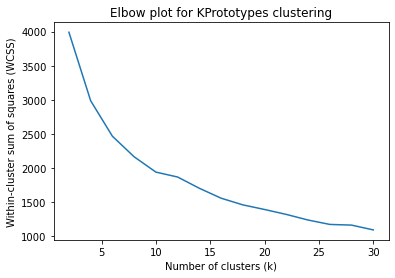

In [61]:
# plot the WCSS against k
plt.plot(k_range, wcss)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow plot for KPrototypes clustering')
plt.show()

In [62]:
# Export WCSS file if needed (uncomment to execute)
wcss_file = pd.DataFrame (wcss, columns = ['wcss'])
wcss_file.to_csv('data/interim/clustering/wcss.csv')

#### Final clustering with correct number of clusters

There are two different approaches. Either, the whole database can be used to create the clusters. For more efficiency, a random 1% sample can be used to generate the clusters and then predict the clusters for the full database later one. The uncommented parts of the following describe the latter.

In [63]:
# #create sample for efficiency
c4c_sample = census.sample(frac=0.01, random_state=42)

In [64]:
# If you want to work with the same, uncomment the first line, otherwise the second

# Working with sample
df = c4c_sample

# # Working with full data
# df = c4c

#### Clustering process

In [65]:
# Print start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Define number of clusters as result of ellbow method (16 as result of full clustering)
k = 10

kproto = KPrototypes(n_clusters=k, init='Cao', verbose=1)
clusters = kproto.fit_predict(df,categorical=cat_vars)

# Print start time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

Start Time: 2023-07-09 22:25:10.847944
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 93795, ncost: 20266.926043881693
Run: 1, iteration: 2/100, moves: 17076, ncost: 20159.6341467056
Run: 1, iteration: 3/100, moves: 5810, ncost: 20129.63004393231
Run: 1, iteration: 4/100, moves: 3455, ncost: 20112.514218811968
Run: 1, iteration: 5/100, moves: 3905, ncost: 20073.227295831643
Run: 1, iteration: 6/100, moves: 3357, ncost: 20051.95454874764
Run: 1, iteration: 7/100, moves: 2944, ncost: 20032.64468547028
Run: 1, iteration: 8/100, moves: 4167, ncost: 19999.56411908399
Run: 1, iteration: 9/100, moves: 1959, ncost: 19995.996103810885
Run: 1, iteration: 10/100, moves: 940, ncost: 19995.030132213265
Run: 1, iteration: 11/100, moves: 604, ncost: 19994.46100207868
Run: 1, iteration: 12/100, moves: 457, ncost: 19994.049941234272
Run: 1, iteration: 13/100, mov

Run: 7, iteration: 15/100, moves: 35, ncost: 21805.42405252116
Run: 7, iteration: 16/100, moves: 36, ncost: 21805.420569021044
Run: 7, iteration: 17/100, moves: 29, ncost: 21805.419339399996
Run: 7, iteration: 18/100, moves: 4, ncost: 21805.41924903268
Run: 7, iteration: 19/100, moves: 5, ncost: 21805.419205665276
Run: 7, iteration: 20/100, moves: 1, ncost: 21805.419201095927
Run: 7, iteration: 21/100, moves: 0, ncost: 21805.419201095927
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 56923, ncost: 22850.56311953621
Run: 8, iteration: 2/100, moves: 15969, ncost: 22624.626118295153
Run: 8, iteration: 3/100, moves: 3957, ncost: 22611.501033909164
Run: 8, iteration: 4/100, moves: 938, ncost: 22610.734696674805
Run: 8, iteration: 5/100, moves: 241, ncost: 22610.68103363889
Run: 8, iteration: 6/100, moves: 46, ncost: 22610.679103808587
Run: 8, iteration: 7/100, moves: 8, ncost: 22610.678872815235
Run: 8, iteration: 8/100, move

In [66]:
df.head()

,gender,educ,main_act,vehicle_owned,trips_count,activity,distance,start
17623025,male,1.0,primary,0,0.4,personal,0.001904,0.472608
5956892,male,0.0,work,0,0.2,personal,0.011083,0.582993
15079809,male,0.0,work,0,0.8,personal,0.137022,0.098119
6592718,male,0.0,work,1,0.6,work,0.008559,0.533115
4955767,male,0.0,work,0,0.6,work,0.010418,0.488144


In [67]:
col_names_ordered = ['trips_count', 'distance', 'start', 'gender', 'educ', 'main_act', 
                     'vehicle_owned', 'activity']

In [68]:
# Access center values of cluster centroids
centers = kproto.cluster_centroids_
centers = pd.DataFrame(centers, columns=col_names_ordered)

In [69]:
centers.head(10)

,trips_count,distance,start,gender,educ,main_act,vehicle_owned,activity
0,0.5533050145045402,0.015730656568250043,0.43212308363767166,male,0.0,work,0,personal
1,0.34685505271431255,0.0042788942169380674,0.5076225543679167,female,1.0,primary,0,primary
2,0.4301524007210352,0.01174441701075087,0.4909931060868313,female,0.0,work,1,work
3,0.33712812010671944,0.021926483283105907,0.4649383108787113,male,1.0,secondary,0,secondary
4,0.7692144997356521,0.01727305345708845,0.7657823294902459,male,0.0,work,0,work
5,0.18530666274454755,0.01560306251568727,0.421366255943797,male,0.0,work,1,personal
6,0.3081403762662255,0.007331357108748202,0.3345666098287402,male,1.0,primary,0,personal
7,0.6716024877590331,0.018160713911364264,0.3304675688533815,male,0.0,work,1,work
8,0.18553968592335307,0.01106394529887598,0.49255633471515975,female,0.0,work,0,personal
9,0.23519650440625323,0.015626000156283983,0.35398233179184346,male,0.0,work,0,work


In [70]:
# Keep only numeric variables which are used for clustering (here, NE17FR is deleted)
num_vars_clust = ['trips_count', 'distance', 'start']

In [72]:
centers

,trips_count,distance,start,gender,educ,main_act,vehicle_owned,activity
0,0.5533050145045402,0.015730656568250043,0.43212308363767166,male,0.0,work,0,personal
1,0.34685505271431255,0.0042788942169380674,0.5076225543679167,female,1.0,primary,0,primary
2,0.4301524007210352,0.01174441701075087,0.4909931060868313,female,0.0,work,1,work
3,0.33712812010671944,0.021926483283105907,0.4649383108787113,male,1.0,secondary,0,secondary
4,0.7692144997356521,0.01727305345708845,0.7657823294902459,male,0.0,work,0,work
5,0.18530666274454755,0.01560306251568727,0.421366255943797,male,0.0,work,1,personal
6,0.3081403762662255,0.007331357108748202,0.3345666098287402,male,1.0,primary,0,personal
7,0.6716024877590331,0.018160713911364264,0.3304675688533815,male,0.0,work,1,work
8,0.18553968592335307,0.01106394529887598,0.49255633471515975,female,0.0,work,0,personal
9,0.23519650440625323,0.015626000156283983,0.35398233179184346,male,0.0,work,0,work


In [74]:
census

,gender,educ,main_act,vehicle_owned,trips_count,activity,distance,start
0,female,1.0,secondary,0,0.2,shopping,0.003021,0.305805
1,male,0.0,work,0,0.4,personal,0.010812,0.414554
2,male,0.0,work,0,0.4,work,0.011154,0.800491
3,male,0.0,work,0,0.4,work,0.000444,0.267375
4,male,0.0,work,0,0.4,personal,0.001904,0.485691
...,...,...,...,...,...,...,...,...
22946719,male,1.0,uni,0,0.0,shopping,0.001869,0.381030
22946720,male,0.0,work,0,0.8,work,0.009095,0.290270
22946721,male,0.0,work,0,0.8,work,0.012332,0.439902
22946722,male,0.0,work,0,0.8,shopping,0.001576,0.658217


In [80]:
num_vars_clust

['trips_count', 'distance', 'start']

In [81]:
# Re-calculate min and max values of numeric variables used for clustering to reconvert values
nv = {}

for num_var_clust in num_vars_clust:
    min_val = census_raw[num_var_clust].apply(pd.to_numeric, errors='coerce').min()
    max_val = census_raw[num_var_clust].apply(pd.to_numeric, errors='coerce').max()
    
    if num_var_clust not in nv:
        nv[num_var_clust] = []
    
    nv[num_var_clust].append(min_val)
    nv[num_var_clust].append(max_val)

In [82]:
# Reconvert numeric values in original values
for x in num_vars_clust:
    centers[x] = round(centers[x].astype(float) * (nv[x][1] - nv[x][0]) + nv[x][0]).astype(int)

In [84]:
# Access converted centres as csv (only export here if the sample was high enough)
centers.to_csv('data/interim/clustering/centers.csv', index=False)

In [ ]:
# # Add cluster IDs to initial file
# df['CLUSTER'] = clusters

In [85]:
# save the kproto object to a file
with open('data/interim/clustering/kproto.pkl', 'wb') as f:
    pickle.dump(kproto, f)

#### Predict cluster for whole dataset with existing kproto

In [272]:
# # load the saved kproto object from a file (we loaded a kproto from a full sample clustering)
# with open('data/interim/kproto_100pct.pkl', 'rb') as f:
#     kproto = pickle.load(f)

In [86]:
len(census)

22946724

In [87]:
census.head()

,gender,educ,main_act,vehicle_owned,trips_count,activity,distance,start
0,female,1.0,secondary,0,0.2,shopping,0.003021,0.305805
1,male,0.0,work,0,0.4,personal,0.010812,0.414554
2,male,0.0,work,0,0.4,work,0.011154,0.800491
3,male,0.0,work,0,0.4,work,0.000444,0.267375
4,male,0.0,work,0,0.4,personal,0.001904,0.485691


In [88]:
# use existing kproto object to predict clusters for new data
clusters_full = kproto.predict(census, categorical=cat_vars)

In [90]:
len(clusters_full)

22946724

In [91]:
# Attach clusters to scaled dataframe 
census['CLUSTER'] = clusters_full
census['CLUSTER'].value_counts().sort_values()

5    1347683
7    1513909
4    1711681
2    1834809
0    1930824
3    2151902
1    2797396
6    2800016
8    2815437
9    4043067
Name: CLUSTER, dtype: int64

In [92]:
census.head()

,gender,educ,main_act,vehicle_owned,trips_count,activity,distance,start,CLUSTER
0,female,1.0,secondary,0,0.2,shopping,0.003021,0.305805,3
1,male,0.0,work,0,0.4,personal,0.010812,0.414554,0
2,male,0.0,work,0,0.4,work,0.011154,0.800491,4
3,male,0.0,work,0,0.4,work,0.000444,0.267375,9
4,male,0.0,work,0,0.4,personal,0.001904,0.485691,0


In [93]:
# Export clusters as individual csv
clusters = pd.DataFrame(clusters_full)
clusters.to_csv('data/interim/clustering/clusters.csv', index=False)

In [94]:
# Export df census with attached clusters
census.to_csv('data/interim/clustering/census_clustered.csv', index=False)

# Working area to save person_id with cluster

In [37]:
clusters = pd.read_csv('data/interim/clustering/clusters.csv')

In [40]:
census_temp = census_temp.drop(labels=['Unnamed: 0','age', 'gender', 'educ', 'geometry', 'age_det',
                                        'main_act', 'profile_id', 'vehicle_owned', 
                                        'trips_count', 'activities', 'repetition', 'act_id',
                                        'activity', 'distance', 'start', 'end'], axis=1)

In [42]:
census_temp['CLUSTER'] = clusters

In [44]:
census_temp = census_temp.rename(columns={'index': 'person_id'})

In [47]:
census_temp = census_temp.groupby('person_id').first().reset_index()

In [50]:
# Export df census with attached clusters
census_temp.to_csv('data/interim/clustering/person_ids_clustered.csv', index=False)